# Overview

In this tutorial we will explore several strategies to address class imbalance as well as how to tune a network with weighted loss functions (e.g. class weights and masks). Strategies discussed include:

* stratified sampling
* pixel-level class weights
* pixel-level masked loss
* focal loss
* Dice score loss

Ultimately, the goal of this tutorial (and class assignment) is to create a high sensitivity detector for kidney tumor on CT exams. 

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [1]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 89 kB 3.9 MB/s 
     |████████████████████████████████| 596 kB 17.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [2]:
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, models, losses, layers, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of kidney tumor CT exams derived from the Kidney Tumor Segmentation Challenge (KiTS). More information about he KiTS Challenge can be found here: https://kits21.kits-challenge.org/. In this exercise, we will use this dataset to derive a model for slice-by-slice kidney segmentation. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/ct_kits`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [3]:
# --- Download dataset
datasets.download(name='ct/kits')

[ 2022-05-21 18:58:14 ] [====================] 100.000% : Extracting archive (0000818 / 0000818) 

{'code': '/data/raw/ct_kits', 'data': '/data/raw/ct_kits'}

### Stratified Sampling

The first strategy we explore to address class imbalance is stratified sampling e.g., we will increase the sampling frequency of slices with enhancing tumor to approximately 30%. More precisely, we will use the following sampling distribution:

* class 0: 40% (background)
* class 1: 30% (normal kidney)
* class 2: 30% (tumor)

To do so, we pass the appropriate `sampling` specifications to the `configs` variable when creating the data generators and the `Client()` object:

In [4]:
# --- Configs dict
configs = {
    'batch': {'size': 16},
    'sampling': {
        'lbl-crp-00': 0.4,
        'lbl-crp-01': 0.3,
        'lbl-crp-02': 0.3}}

# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='ct/kits', keyword='2d', configs=configs, custom_layers=True)

The created generators yield a total of `batch['size']` training samples based on the specified batch size. As before, each iteration yields dictionary of model inputs, `xs`. In the current example, there is just a single input image `xs['dat']` and a single target `xs['lbl']`. Let us examine the generator data:

In [5]:
# --- Yield one example
xs, _ = next(gen_train)

# --- Print dict keys
for k, v in xs.items():
    print('key = {} : shape = {}'.format(k.ljust(7), v.shape))

key = dat     : shape = (16, 1, 96, 96, 1)
key = lbl     : shape = (16, 1, 96, 96, 1)


### KITS Data

The input images in the variable `dat` are matrices of shape `1 x 96 x 96 x 1`. Note that even though the images here are 2D in shape, the full matrix is a 3D tensor `(z, y, x)` where `z = 1` in this implementation. Note that although the 3rd z-axis dimension is redundant here (for a single slice input), many of our more complex models and architectures will commonly require a full 3D tensor. Because of this, we will directly use 3D convolutions throughout the tutorial materials for consistency.

Use the following lines of code to visualize using the `imshow(...)` method:

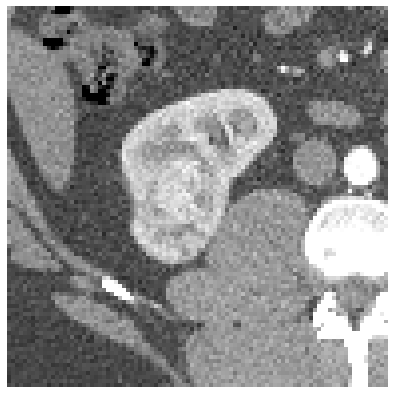

In [6]:
# --- Show the first example
imshow(xs['dat'][0])

Use the `montage(...)` function to create an N x N mosaic of all images:

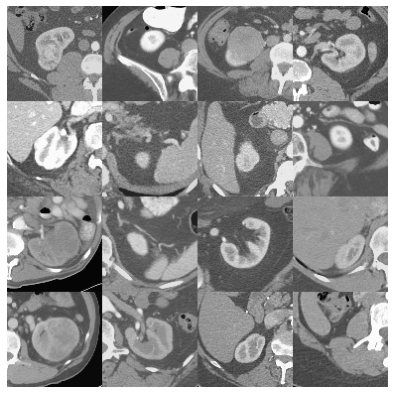

In [7]:
# --- Show "montage" of all images
imshow(xs['dat'])

### Kidney masks

The ground-truth labels are three class masks of the same matrix shape as the model input:

In [8]:
print(xs['lbl'][0].shape)

(1, 96, 96, 1)


The three classes represent:

* class 0: background
* class 1: normal kidney
* class 2: tumor

Use the `imshow(...)` method to visualize the ground-truth tumor mask labels:

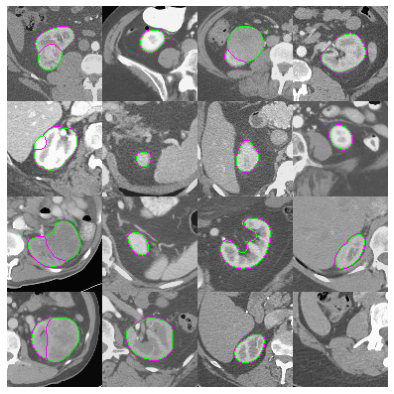

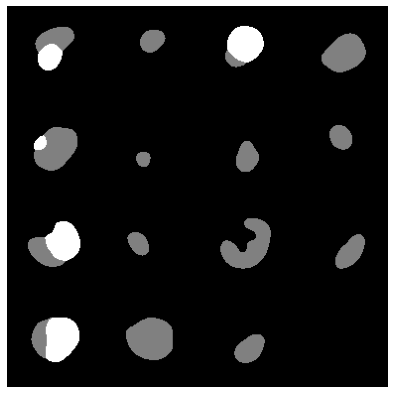

In [9]:
# --- Show tumor masks overlaid on original data
imshow(xs['dat'], xs['lbl'])

# --- Show tumor masks isolated
imshow(xs['lbl'])

# Model

To localize tumor, we will implement a standard contracting-expanding network for semantic segmentation (e.g. U-Net). In the assignment, feel free to try various architecture permutations.

### Create backbone

Define standard lambda functions:

In [10]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same'}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)
tran = lambda x, filters, strides : layers.Conv3DTranspose(filters=filters, strides=strides, **kwargs)(x)

concat = lambda a, b : layers.Concatenate()([a, b])

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2))))
tran2 = lambda filters, x : relu(norm(tran(x, filters, strides=(1, 2, 2))))

Define standard U-Net backbone:

In [ ]:
# --- Input input
x = Input(shape=(None, 96, 96, 1), dtype='float32')

# --- Define contracting layers
l1 = conv1(8, x)
l2 = conv1(16, conv2(16, l1))
l3 = conv1(32, conv2(32, l2))
l4 = conv1(48, conv2(48, l3))
l5 = conv1(64, conv2(64, l4))

# --- Define expanding layers
l6  = tran2(48, l5)
l7  = tran2(32, conv1(48, concat(l4, l6)))
l8  = tran2(16, conv1(32, concat(l3, l7)))
l9  = tran2(8,  conv1(16, concat(l2, l8)))
l10 = conv1(8,  l9)

# --- Create logits
logits = layers.Conv3D(filters=2, **kwargs)(l10)

# --- Create model
backbone = Model(inputs=x, outputs=logits) 

# Training model

Next, the `backbone` model architecture is wrapped in a second model with additional layer(s) that define optimization behavior including loss function derivations.

### Inputs

As before, we start by defining all `inputs` into our new *wrapper* model.

In [ ]:
# --- Create inputs
inputs = {
    'dat': Input(shape=(None, 96, 96, 1), dtype='float32'),
    'lbl': Input(shape=(None, 96, 96, 1), dtype='uint8')}

Using this `inputs` Python dictionary, let us first recreate the CNN model operations by **reusing** the `backbone` object that we already defined. Doing so means that our new *wrapper* model is explicitly derived from the `backbone`. Any updates applied to our new *wrapper* model are propogated to the `backbone` model and vice versa. 

In [ ]:
# --- Define first step of new wrapper model
logits = backbone(inputs['dat'])

## Weighted Loss

To implement custom loss weights (and/or masks), create a `wgt` array to perform a point-wise multiplication against the final pixel-by-pixel loss. For locations where the loss should be **weighted**, use a constant value > 1, For locations where the loss should be ignored (**masked**), use a constant value of 0.

### Implementation

There three different custom class weight `wgt` tensors that will be explored in this tutorial:

**Variant 1**: Use class weights to increase the penalty for tumor voxels

In [ ]:
def create_weights(lbl, pos_weight=5.0):
    
    # --- Create wgt
    wgt = tf.ones_like(lbl, dtype='float32')
    wgt = wgt + tf.cast(lbl == 2, dtype='float32') * (pos_weight - 1.0)
    
    return wgt

**Variant 2**: Use a masked loss function to ignore the contribution of non-kidney voxels

In [ ]:
def create_weights(lbl):
    
    # --- Create wgt
    wgt = tf.cast(lbl > 0, dtype='float32')
    
    return wgt

**Variant 3**: Use a combination of both class weights and masked losses

* class 0 (background; non-kidney): set `wgt` to 0
* class 1 (background; kidney): set `wgt` to 1
* class 2 (foreground; tumor): set `wgt` to positive value

In [ ]:
def create_weights(lbl, pos_weight=5.0):

    pass

Now let's create the `wgt` tensor:

In [ ]:
# --- Create weights
wgt = create_weights(inputs['lbl'])

### Target ground-truth

Additionally, while our ground-truth `inputs['lbl']` currently comprises of three separate classes (background, kidney, tumor), we will be predicting a binary segmentation output of tumor vs. no tumor only. Thus in addition to creating a `wgt` array, we will be creating an additional binarized `y_true` ground-truth array.

In [ ]:
# --- Create y_true (binarized ground-truth)
y_true = tf.cast(inputs['lbl'] == 2, dtype='uint8')

### Loss

As in prior tutorials, a standard (sparse) softmax cross-entropy loss will be used to optimize the segmentation model. In addition, however, ensure that the custom `wgt` tensor above is passed into the loss function in the `sample_weight` keyword argument. Doing so will define a point-wise multiplication between the softmax cross-entropy loss and the corresponding weight value (stipulated in `wgt`).

In [ ]:
# --- Create loss
sce = losses.SparseCategoricalCrossentropy(from_logits=True)(
    y_true=y_true,
    y_pred=logits,
    sample_weight=wgt)

### Metrics

The goal of weighted and/or masked loss functions in this example is maximize the sensitivity for tumor prediction. Thus, in addition to a standard Dice score metric, we will additionally use foreground sensitivity to track overall model performance.

To adjust the metrics to account for a custom weighted loss function, one must simply ignore predictions from masked regions (e.g., the model is required to predict accurate results in these regions). 

**Checkpoint**: No modification is needed to account for class weights. Why is this true?

In [ ]:
def calculate_dsc(y_true, y_pred, weights=None, c=1):
    """
    Method to calculate the Dice score coefficient for given class
    
    :params
    
      y_true : ground-truth label
      y_pred : predicted logits scores
           c : class to calculate DSC on
    
    """    
    true = y_true[..., 0] == c
    pred = tf.math.argmax(y_pred, axis=-1) == c 
    
    if weights is not None:
        true = true & (weights[..., 0] != 0)
        pred = pred & (weights[..., 0] != 0)

    A = tf.math.count_nonzero(true & pred) * 2
    B = tf.math.count_nonzero(true) + tf.math.count_nonzero(pred)
    
    return tf.math.divide_no_nan(
        tf.cast(A, tf.float32), 
        tf.cast(B, tf.float32))

In [ ]:
def calculate_sen(y_true, y_pred, weights=None, c=1, **kwargs):
    """
    Method to implement sensitivity (recall) on raw cross-entropy logits

    """
    true = y_true[..., 0] == c
    pred = tf.math.argmax(y_pred, axis=-1) == c 
    
    if weights is not None:
        true = true & (weights[..., 0] != 0)
        pred = pred & (weights[..., 0] != 0)
        
    tp = true & pred

    num = tf.math.count_nonzero(tp) 
    den = tf.math.count_nonzero(y_true)

    num = tf.cast(num, tf.float32)
    den = tf.cast(den, tf.float32)

    return tf.math.divide_no_nan(num, den)

Use the following code block to create weighted metrics:

In [ ]:
# --- Create metrics
dsc = calculate_dsc(y_true, logits, wgt)
sen = calculate_sen(y_true, logits, wgt)

### Create model

Now let us create the new wrapper model. The inputs are defined above already in our `inputs` Python dictionary. We will name this new wrapper model `training` because it will be used for training only. 

In [ ]:
training = Model(inputs=inputs, outputs={'logits': logits, 'dsc': dsc, 'sen': sen})

Now let's add the `loss` and `metric` tensors we defined above to the new `training` model:

In [ ]:
# --- Add losses
training.add_loss(sce)

# --- Add metric
training.add_metric(dsc, name='dsc')
training.add_metric(sen, name='sen')

### Compile model

 To prepare the model for learning, a graph must be **compiled** with a strategy for optimization.

In [ ]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=2e-4)

# --- Compile model
training.compile(optimizer=optimizer)

# Training

### In-memory data

For moderate sized datasets which are too large to fit into immediate hard-drive cache, but small enough to fit into RAM memory, it is often times a good idea to first load all training data into RAM memory for increased speed of training. The `client` can be used for this purpose as follows:

In [ ]:
# --- Load data into memory for faster training
client.load_data_in_memory()

### Tensorboard

To use Tensorboard, create the necessary Keras callbacks:

In [ ]:
from tensorflow.keras import callbacks  
tensorboard_callback = callbacks.TensorBoard('./logs')

Now, let us train the model:

In [ ]:
# --- Train model
training.fit(
    x=gen_train, 
    steps_per_epoch=100, 
    epochs=20,
    validation_data=gen_valid,
    validation_steps=100,
    validation_freq=5,
    use_multiprocessing=True,
    callbacks=[tensorboard_callback])

### Launching Tensorboard

After running several iterations, start Tensorboard using the following cells. After Tensorboard has registered the first several checkpoints, subsequent data will be updated automatically (asynchronously) and model training can be resumed:

In [ ]:
% load_ext tensorboard
% tensorboard --logdir logs

# Evaluation

To test the trained model, the following steps are required:

* load data
* use `model.predict(...)` to obtain logit scores
* compare prediction with ground-truth (Dice score, sensitivity)
* serialize in Pandas DataFrame

Recall that the generator used to train the model simply iterates through the dataset randomly. For model evaluation, the cohort must instead be loaded manually in an orderly way. For this tutorial, we will create new **test mode** data generators, which will simply load each example individually once for testing. 

In [ ]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True)

To run prediction on a single (first) example from the generator:

In [ ]:
# --- Run a single prediction
x, y = next(test_valid)
outputs = training.predict(x)

Let us visualize the predicted results. Recall that the `np.argmax(...)` function can be used to convert raw logit scores to predictions:

In [ ]:
# --- Create prediction
pred = np.argmax(outputs['logits'][0], axis=-1)

# --- Show
imshow(x['dat'][0, ..., 0], pred)

**Checkpoint:** If you use variant 2 or 3, what is the problem with this mask?

Recall that during training, the algorithm is never penalized regardless of class for predictions *outside of the mask* (e.g. values == 0) used for training. Thus, to generate the final prediction, one needs to similarly remove the masked values of the prediction. How do we accomplish this?

In [ ]:
# --- Clean up pred using mask
pred[x['lbl'][0, ..., 0] == 0] = 0

# --- Show
imshow(x['lbl'][0, ..., 0], pred)

**Checkpoint**: Are the `outputs['dsc']` and `'outputs['sen']` predictions valid as is, or do these metrics need to be modified as shown in the code cell above?

### Running evaluation

The following sets up the inference loop. Note that only cases with a tumor need to checked for accuracy as Dice score and sensitivity are both only defined when a target object is present.

In [ ]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True)

dice = []
sens = []

for x, y in test_valid:
    
    # --- Check if tumor is present
    if (x['lbl'] == 2).any():
    
        # --- Create prediction
        outputs = training.predict(x)

        # --- Aggregate Dice
        dice.append(outputs['dsc'])

        # --- Aggregate sens
        sens.append(outputs['sen'])

# --- Convert to Numpy
dice = np.array(dice)
sens = np.array(sens)

### Saving results

In [ ]:
# --- Define columns
df = pd.DataFrame(...)
df['dice'] = ...
df['sens'] = ...

## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `backbone.save()` and `backbone.load_model()` methods. 

In [ ]:
# --- Serialize a model
backbone.save('./model.hdf5')

In [ ]:
# --- Load a serialized model
del backbone
backbone = models.load_model('./model.hdf5', compile=False)

# Exercises

In this tutorial, we presented a general strategy for creating custom loss functions using the Tensorflow / Keras API with a focus on strategies for class imbalance. In addition to weighted and masked loss functions, two other alternative (often complimentary) approaches include the **focal loss** and **soft Dice loss**. While these strategies are not required for the weekly homework assignment, these optional exercises will provide you an opportunity to become familiar with creating and customizing your own loss functions in Tensorflow / Keras. 

### Exercise 1

In this exercise, create a custom implementation of the focal loss. As you recall, the **focal loss** function gradually titrates the contribution of any given prediction such that more confident correct predictions over time become weighted less than incorrect predictions:

```
focal loss = -(1 - p[t]) ** y * alpha * log(p[t])

```
Where:

* `p[t]`: sigmoid transformation of raw logit prediction on between `[0, 1]`
* `alpha`: weight for cross-entropy loss
* `y`: gamma value for focal loss (y == 0 for no focal loss, y > 1 for more focal loss)

![Focal Loss](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2022/notebooks/box_localization/pngs/focal_loss.png)

In [ ]:
def focal_sigmoid_ce(y_true, y_pred, weights=1.0, scale=1.0, gamma=2.0, alpha=0.25):
    """
    Method to implement focal sigmoid (binary) cross-entropy loss

    """
    # --- Calculate standard cross entropy with alpha weighting
    loss = ...

    # --- Calculate modulation to pos and neg labels 
    p = ...
    modulation_pos = ...
    modulation_neg = ...

    mask = tf.dtypes.cast(y_true, dtype=tf.bool)
    modulation = tf.where(mask, modulation_pos, modulation_neg)

    return tf.math.reduce_sum(modulation * loss * weights * scale)

**Hint:** Consider the following two-step implementation approach:

1. `alpha * log(p[t])`: This term is essentially the same as the standard weighted cross entroy loss. Is there a Tensorflow / Keras loss function that we can use to implement this component of the focal loss function?

2. `(1 - p[t]) ** y`: This term requires scaling or modulating the loss by the *confidence* of prediction. For the positive class, probablity values close to 1.0 indicate confident, correct predictions. For the negative class, probability values close to 0.0 indicate confident, correct predictions. Consider calcuating the modulation scaling factor for both positive and negative classes separately, and using `tf.where(...)` to combine the two tensors based on ground-truth. Also don't forget to convert `y_pred` (logits) to probability using a sigmoid transform using `tf.math.sigmoid(...)`.

### Exercise 2

In this exercise, we will modify the standard Dice score function to allow for differentiation. Recall that the Dice score is calculated as follows:

* numerator: overlap of A and B (multiplied by 2)
* denominator: |A| + |B|

For modification, we will replace the overlap with a multiplication by the **softmax** normalization of the logits and the ground-truth mask. In addition, we will replace the `|A|` with the total sum of the **softmax** normalized logits.

In [ ]:
def dsc_soft(y_true, y_pred, weights=None, scale=1.0, epsilon=1, cls=1):
    """
    Method for soft (differentiable) Dice score calculation

    :params

      (int) cls : class to use to for Dice score calculation (default = 1)

    """
    true = tf.cast(y_true[..., 0] == cls, tf.float32)
    pred = ...

    if weights is not None:
        true = true * (weights[..., 0]) 
        pred = pred * (weights[..., 0])

    num = ...
    den = ...

    return -(num / den) * scale

**Hint**: While the ground-truth masks may remain binary, to ensure a differentiable function, the **softmax** transform of the logits is used for the prediction tensor. To implement this loss properly, ensure that the `pred` tensor above accounts for the softmax normalization and that the appropriate modifications are made to both the numerator and denominator of the Dice score calculation above.